# Weather Image Classification
*Created by Ade Dwi Aryani*

# 1. Introduction

Cuaca merupakan faktor penting yang dipertimbangkan untuk berbagai pengambilan keputusan. Klasifikasi cuaca manual oleh manusia membutuhkan waktu yang lama dan inkonsistensi. Computer vision adalah cabang ilmu yang digunakan komputer untuk mengenali atau melakukan klasifikasi citra. Hal ini dapat membantu pengembangan self autonomous machine agar tidak bergantung pada koneksi internet dan dapat melakukan kalkulasi sendiri secara real time. 

Dataset yang digunakan dalam penelitian ini adalah citra cuaca yang didapatkan dari Multi-class Weather dataset for image classification yang dapat diunduh di [kaggle](https://www.kaggle.com/datasets/saurabhshahane/multi-class-weather-dataset). Terdapat empat kelas cuaca, yaitu cloudy, rain, shine, dan sunrise.

Analisis ini bertujuan untuk mengklasifikasikan gambar cuaca ke dalam kelasnya masing-masing dengan menggunakan algoritma Convolutional Neural Network (CNN). 

## 2. Import Libraries

Sebelum memulai analisis *image classification* diperlukan berbagai pustaka atau library yang dapat memudahkan proses. Pustaka yang dibutuhkan harus sesuai dengan data, model, dan metode yang digunakan dalam analisis. Pustaka yang dibutuhkan pada analisis ini adalah sebagai berikut:

In [42]:
from google.colab import drive
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import pathlib
import random

# For Preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For Modelling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report

# Saving Model
from keras.models import load_model

# For Data Inference
from google.colab import files
from tensorflow.keras.preprocessing import image

# 3. Data Loading

Dataset yang akan digunakan berada di file google drive. Untuk menghubungkan file yang ada di google drive dengan google colab, maka harus dilakukan mounting google drive pada directory google colab. Setelah dilakukan mounting maka sebuah folder ‘gdrive’ akan muncul pada directory VM Google Colab. 

In [43]:
# Mounting the drive with name 'gdrive'
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Untuk mengakses folder, maka harus mengubah directory google drive sebagai berikut.

In [44]:
# Change to the google drive directory
% cd /content/gdrive/MyDrive/weather_cnn

/content/gdrive/MyDrive/weather_cnn


Untuk memastikan sudah berada di folder yang tepat, dapat menggunakan `! pwd`.

In [45]:
# For verifying
! pwd

/content/gdrive/MyDrive/weather_cnn


# 4. Exploratory Data Analysis (EDA)

Eksplorasi data yang akan dijelaskan berfokus pada data training yang berada di folder train (`weather_img/train/`). Terdapat dua folder pada `weather_img/` yaitu train dan test. Data training digunakan untuk melatih algoritma, sedangkan data testing digunakan sebagai data validation, yaitu data yang digunakan untuk proses validasi model dan mencegah overfitting.

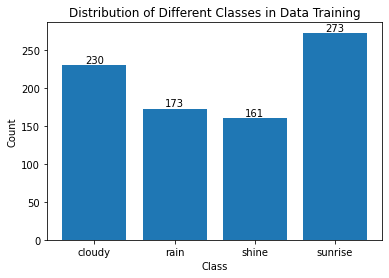

In [46]:
# Function to add value labels
image_folder = ['cloudy', 'rain', 'shine', 'sunrise']
nimgs = {}
for i in image_folder:
    nimages = len(os.listdir('/content/gdrive/MyDrive/weather_cnn/weather_img/train/'+i+'/'))
    nimgs[i]=nimages

f, axe = plt.subplots(1, 1, figsize=(6,4))
plt.bar(image_folder, list(nimgs.values()), align='center')
axe.bar_label(axe.containers[0], fontsize=10)
axe.yaxis.tick_left()
axe.set(xlabel='Class', ylabel='Count', title='Distribution of Different Classes in Data Training');

Terdapat empat kelas cuaca pada data train maupun test, yaitu cloudy, rain, shine, dan sunrise. Pada data train, kelas dengan data tertinggi yaitu sunrise, yakni 273 gambar. Kedua adalah cloudy, yakni 230 gambar. Ketiga adalah rain, yakni 173 gambar. Yang terakhir adalah shine berisi 161 gambar.

Berikut adalah penjelasan beberapa contoh gambar dari masing-masing kelas. Gambar yang akan ditampilkan adalah 9 gambar yang dipilih secara random dengan menggunakan fungsi `view_random_image`, yang didefinsikan sebagai gambar yang diambil secara random dari target folder yaitu folder train dan target class yaitu cloudy, rain, shine, atau sunrise. Pada random image ini juga menambahkan ukuran gambar dari setiap gambar.

In [47]:
# Show Random Image
def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class

  # Random Sample Image
  random_image = random.sample(os.listdir(target_folder), 1)

  images = imread(target_folder + "/" + random_image[0])
  plt.imshow(images)
  plt.title(f"Shape: {images.shape}", fontsize=10)
  plt.axis("off");
  return images

## Cloudy Images

*Cloudy* atau cuaca berawan adalah kondisi cuaca disaat terlihat banyak awan di langit. Cahaya matahari akan ditutupi oleh awan sehingga membuat suhu permukaan bumi seketika tidak terasa panas. Beberapa awan akan ikut bergerombol dan membentuk awan yang besar. Awan besar ini bisa berpotensi mendung sehingga sebagai tanda akan turunnya hujan.

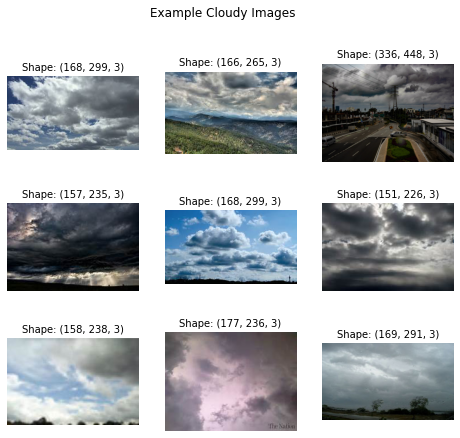

In [48]:
# Plot Cloudy Image
plt.figure(figsize=(8,7))
for i in range(9):
  plt.subplot(3, 3, i+1)
  images = view_random_image(target_dir='weather_img/train/', target_class='cloudy')
  plt.imshow(images)

plt.suptitle('Example Cloudy Images')
plt.show()

Ciri khas dari cloudy image adalah gambar didominasi oleh awan yang berwarna abu-abu. Beberapa awan berwarna abu gelap dan hitam, yang menandakan kondisi sedang mendung. Untuk ukuran, ukuran pada class cloudy beragam atau memiliki ukuran yang berbeda di setiap gambar, tapi didominasi oleh gambar berukuran landscape. Beberapa gambar memiliki latar tempat, seperti gambar jalan, pepohonan, dan perkotaan. Namun, dari keseluruhan gambar, gambar yang mendominasi adalah gambar yang hanya berisi awan.

## Rain Images

Cuaca hujan atau *rain* adalah kondisi ketika air menguap karena suhu panas dari terik matahari, maka terbentuklah uap air. Uap tersebut, yang mengandung partikel-partikel air, naik ke atas dan  semakin meninggi ke langit. Saat uap air berkumpul dan menjadi padat, lalu terbentuklah awan. Oleh karena adanya hembusan angin, semakin banyak awan yang terkumpul, semakin bertambah besar awan tersebut dan berwarna kelabu. Semakin kelabu warnanya, partikel-partikel air itu semakin berat. Dan ketika partikel-partikel air tersebut tidak terbendung lagi, partikel-partikel tersebut jatuh ke bumi dan turunlah hujan.

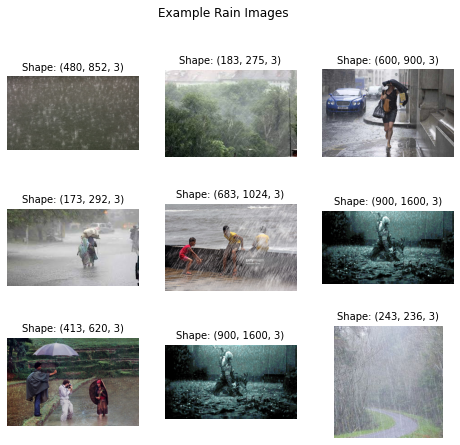

In [49]:
# Plot Rain Images
plt.figure(figsize=(8,7))
for i in range(9):
  plt.subplot(3, 3, i+1)
  images = view_random_image(target_dir='weather_img/train/', target_class='rain')
  plt.imshow(images)

plt.suptitle('Example Rain Images')
plt.show()

Gambar hujan pada dataset memiliki ciri khas terdapat air yang mengalir membentuk hujan. Warna yang mendominasi adalah warna abu-abu. Latar pada gambar bermacam-macam dan berbeda di setiap gambar, yaitu latar orang-orang yang sedang melakukan kegiatan dengan menggunakan payung atau tanpa payung, kendaraan, pepohonan, bukit, dan lain-lain. Ukuran pada gambar hujan juga berbeda di setiap gambar, tapi didominasi oleh gambar berbentuk landscape.

## Shine Images

Cuaca cerah atau *shine* adalah ketika matahari bersinar terang dan udara terasa segar atau terasa terik dan hujan tidak turun. Pada siang hari, terdapat awan tipis berwarna putih, seperti kapas. 

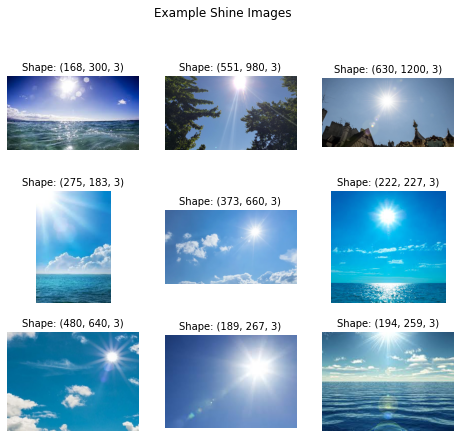

In [50]:
# Plot Shine Images
plt.figure(figsize=(8,7))
for i in range(9):
  plt.subplot(3, 3, i+1)
  images = view_random_image(target_dir='weather_img/train/', target_class='shine')
  plt.imshow(images)

plt.suptitle('Example Shine Images')
plt.show()

Ciri khas dari shine image adalah terdapat kilauan matahari. Warna yang mendominasi adalah warna biru yang menandakan langit cerah, atau hijau yang menandakan pepohonan. Latar pada gambar shine juga bermacam-macam yaitu langit biru, pepohanan, pantai, dan lain-lain. Ukuran di setiap gambar juga berbeda, tapi didominasi oleh gambar berukuran landscape.

## Sunrise Images

Sunrise merupakan istilah yang merujuk pada fenomena terbitnya matahari. Matahari terbit adalah peristiwa di mana sisi teratas Matahari muncul di atas horizon di sebelah timur. Sunrise merupakan momen di mana matahari mulai muncul atau di Indonesia, terbit dari arah timur.

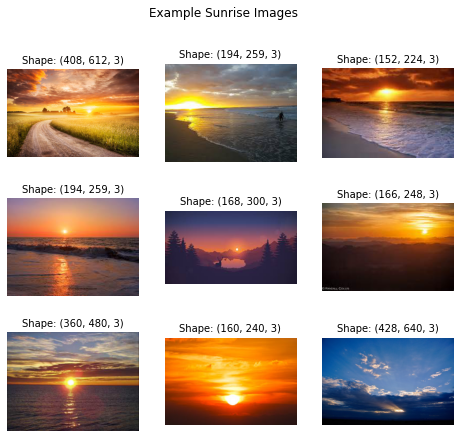

In [51]:
# Plot Sunrise Images
plt.figure(figsize=(8,7))
for i in range(9):
  plt.subplot(3, 3, i+1)
  images = view_random_image(target_dir='weather_img/train/', target_class='sunrise')
  plt.imshow(images)

plt.suptitle('Example Sunrise Images')
plt.show()

Yang menjadi ciri khas *sunrise images* adalah terdapat gambar matahari yang baru mulai muncul. Bentuk mataharinya berupa satu lingkaran atau setengah lingkaran, berbeda-beda setiap gambar. Ada pula gambar yang tidak terdapat gambar matahari namun terdapat sinar berwarna orange, yang menandakan sinar matahari terbit. Warna yang mendominasi pada *sunrise images* adalah orange. Latar pada gambar berbeda di setiap gambar, antara lain laut, pegunungan, awan, perbukitan, dan lain-lain. Ukuran pada *sunrise images* juga berbeda di setiap gambar, tapi didominasi oleh gambar berukuran landscape.

# 5. Data Preprocessing

Data preprocessing berisi proses penyiapan data untuk proses pelatihan model, seperti pembagian data menjadi train-test, transformasi data, dan proses-proses lain yang dibutuhkan. 

Pada analisis ini, dataset dibagi menjadi dua yaitu data train dan data test. Pembagian dilakukan secara manual dengan perbandingan 7.5:2.5 (75% data train, 25% data test), dari pembagian tersebut data kemudian dibagi menjadi dua folder. Untuk melihat jumlah dari setiap data pada masing-masing folder, dapat mengatur *directory*, kemudian untuk melihat data pada setiap target class dapat menggunakan `os.path.join`. Jumlah data pada data train dan data test untuk masing-masing target classnya adalah sebagai berikut:

In [52]:
# Set Directory
train_dir = 'weather_img/train/'
test_dir = 'weather_img/test/'

# Set Directory trainset for Target Class
train_cloudy  = os.path.join(train_dir, 'cloudy/')
train_rain    = os.path.join(train_dir, 'rain/')
train_shine   = os.path.join(train_dir, 'shine/')
train_sunrise = os.path.join(train_dir, 'sunrise/')

print('Number of Data Training by Target Class')
print('Cloudy  :', len(os.listdir(train_cloudy)))
print('Rain    :', len(os.listdir(train_rain)))
print('Shine   :', len(os.listdir(train_shine)))
print('Sunrise :', len(os.listdir(train_sunrise)))

# Set Directory Testing for Target Class
test_cloudy  = os.path.join(test_dir, 'cloudy/')
test_rain    = os.path.join(test_dir, 'rain/')
test_shine   = os.path.join(test_dir, 'shine/')
test_sunrise = os.path.join(test_dir, 'sunrise/')

print(' ')
print('Number of Data Testing by Target Class')
print('Cloudy  :', len(os.listdir(test_cloudy)))
print('Rain    :', len(os.listdir(test_rain)))
print('Shine   :', len(os.listdir(test_shine)))
print('Sunrise :', len(os.listdir(test_sunrise)))

Number of Data Training by Target Class
Cloudy  : 230
Rain    : 173
Shine   : 161
Sunrise : 273
 
Number of Data Testing by Target Class
Cloudy  : 57
Rain    : 42
Shine   : 43
Sunrise : 85


Jika diperhatikan, format folder dataset pada google drive adalah seperti berikut.

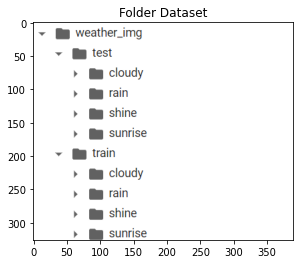

In [53]:
# Folder Data
folder = imread('/content/gdrive/MyDrive/weather_cnn/weather_img/folder.png')
plt.imshow(folder)
plt.title('Folder Dataset')
plt.show()

Format tersebut adalah format standar untuk image classification. Ketika format foldernya sudah seperti itu, framework seperti Tensorflow sudah menyediakan cara mudah untuk meload data. Pada Tensorflow kita bisa menggunakan perintah berikut untuk meload dataset.

In [54]:
# Declare Data Image
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Declare Data Image Augmented
train_datagen_aug = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range = 30,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    zoom_range = 0.2,
                    shear_range = 0.3,
                    horizontal_flip = True)

Objek datagen adalah objek ImageDataGenerator() yang berfungsi untuk memproses data sebelum di load. Ada banyak fungsi di dalamnya. Pada analisis ini data validation hanya menggunakan fungsi rescale. Fungsi rescale digunakan untuk mengubah skala nilai pada data image. Ketika data image itu di load, data image direpresentasikan sebagai array 3D (atau Tensor) dengan nilai rentangan antara 0..255. Pada parameter rescale bernilai “1/255” yang artinya setiap nilai akan dikali 1/255 sehingga rentangan nilainya akan berubah diantara 0..1.

ImageDataGenerator() pada data train dilakukan dua kali, yaitu data train yang hanya menggunakan fungsi rescale, dan data train augmented yaitu dengan fungsi lainnya. Pada analisis ini data train agumented menggunakan fungsi sebagai berikut:
1. rescale = 1./255,
2. rotation_range = 30,
3. width_shift_range = 0.2,
4. height_shift_range = 0.2,
5. zoom_range = 0.2,
6. shear_range = 0.3, dan
7. horizontal_flip = True.

Hasil dari ImageDataGenerator() kemudian akan dihubungkan dengan directory data train dan data test dengan menggunakan `flow_from_directory`. Parameter yang ditambahkan adalah :
1. batch_size=32,
2. shuffle=False,
3. target_size=(224, 224),
4. class_mode='categorical', dan
5. seed=46.



In [55]:
# Flow_from_directory for Generate Image
train_data    = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               shuffle=False,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               seed=46)

val_data     = val_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               shuffle=False,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               seed=46)

# Flow_from_directory for Generate Image Augmented
train_data_aug = train_datagen_aug.flow_from_directory(train_dir,
                                               batch_size=32,
                                               shuffle=False,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               seed=46)

Found 837 images belonging to 4 classes.
Found 227 images belonging to 4 classes.
Found 837 images belonging to 4 classes.


Hasil dari perintah tersebut akan menghasilkan object Tensorflow Dataset, sebuah object yang memudahkan proses pengolahan dataset.

# 6. Model Definition

Model yang digunakan adalah model Convolutional Neural Network (CNN) dan pendefinisiannya menggunakan Sequential API. Model yang akan diuji coba adalah 
1. Base model atau model 1, yaitu model dengan parameter tertentu tanpa dropout dan data train bukan augmented, 
2. Model 2, yaitu model 1 dengan penambahan dropout 0.5, 
3. Model 3, yaitu model dengan parameter tertentu tanpa dropout dan data train augmented, 
4. Model 4, yaitu model 3 dengan penambahan dropout 0.5.

## Base Model / Model 1

Model 1 didefinisikan dengan `Sequential API`. Arsitektur Convolutional Neural Network pada Model 1 dimulai dari citra input berukuran 224×224. Model ini terdapat 4 layer konvolusi dan 4 layer pooling. Pada layer konvolusi pertama dengan jumlah feature map 16, ukuran kernel 3×3, dan menggunakan aktivasi ReLu. Hasil konvolusi pertama lalu dimasukkan pada pooling layer menggunakan max pooling (matriks 2x2). Jumlah feature map pada layer konvolusi kedua, ketiga, dan keempat secara berurutan yaitu 32, 64, dan 128. Pooling layer sama yaitu menggunakan matriks 2x2.

Model selanjutnya diubah menjadi vektor atau 1 dimensi dengan flatten agar dapat masuk pada fully connected layer. 

Pada bagian fully connected layer terdapat operasi neural network dengan 2 hidden layer. Hidden layer pertama dengan jumlah neuron 128 dan menggunakan aktivasi ReLu. Hidden layer kedua dengan jumlah neuron 64 dan menggunakan aktivasi ReLu. Pada output digunakan fungsi aktivasi softmax yang digunakan untuk merubah hasil output dalam distribusi probabilitas menyesuaikan klasifikasi yang dihasilkan output, kelas pada dataset adalah multiclass sehingga menggunakan fungsi aktivasi softmax, angka 4 merupakan jumlah kelas yang terdapat pada dataset.

Model kemudian dicompile menggunakan parameter:
1. loss : categorical_crossentropy, karena class pada dataset berupa multiclass
2. optimizer : Adam dengan learning_rate=0.0001, dan
3. metrics : accuracy.

In [56]:
# Define Model_1 Without Dropout Dense Hidden Layer 1
model_1 = Sequential()

# Convulation & Maxpooling
model_1.add(Conv2D(16, 3, activation='relu', input_shape=(224, 224, 3)))
model_1.add(MaxPool2D(2,2))
model_1.add(Conv2D(32, 3, activation='relu'))
model_1.add(MaxPool2D(2,2))
model_1.add(Conv2D(64, 3, activation='relu'))
model_1.add(MaxPool2D(2,2))
model_1.add(Conv2D(128, 3, activation='relu'))
model_1.add(MaxPool2D(2,2))

# Flattening
model_1.add(Flatten())

# Dense Neural Network with 2 Hidden Layer
model_1.add(Dense(128, activation = 'relu'))
model_1.add(Dense(64, activation = 'relu'))
model_1.add(Dense(4, activation='softmax'))

# Compile Model
model_1.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 26, 26, 64)      

## Model 2

Definisi model 2 sama seperti Model 1 hanya berbeda pada penambahan dropout pada dense hidden layer. Dropout yang ditentukan adalah 0,5.

In [57]:
# Define Model_2 Dropout 0.5 Dense Hidden Layer 1
model_2 = Sequential()

# Convulation & Maxpooling
model_2.add(Conv2D(16, 3, activation='relu', input_shape=(224, 224, 3)))
model_2.add(MaxPool2D(2,2))
model_2.add(Conv2D(32, 3, activation='relu'))
model_2.add(MaxPool2D(2,2))
model_2.add(Conv2D(64, 3, activation='relu'))
model_2.add(MaxPool2D(2,2))
model_2.add(Conv2D(128, 3, activation='relu'))
model_2.add(MaxPool2D(2,2))

# Flattening
model_2.add(Flatten())

# Dense Neural Network with 1 Hidden Layer
model_2.add(Dense(128, activation = 'relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(64, activation = 'relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(4, activation='softmax'))

# Compile Model
model_2.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 26, 26, 64)      

## Model 3

Definisi Model 3 sama seperti Model 1. Model 3 akan berbeda dengan Model 1 pada tahap training karena menggunakan data train yang sudah di-*augmented*.

In [58]:
# Define Model_3 Without Dropout Dense Hidden Layer 2
model_3 = Sequential()

# Convulation & Maxpooling
model_3.add(Conv2D(16, 3, activation='relu', input_shape=(224, 224, 3)))
model_3.add(MaxPool2D(2,2))
model_3.add(Conv2D(32, 3, activation='relu'))
model_3.add(MaxPool2D(2,2))
model_3.add(Conv2D(64, 3, activation='relu'))
model_3.add(MaxPool2D(2,2))
model_3.add(Conv2D(128, 3, activation='relu'))
model_3.add(MaxPool2D(2,2))

# Flattening
model_3.add(Flatten())

# Dense Neural Network with 1 Hidden Layer
model_3.add(Dense(128, activation = 'relu'))
model_3.add(Dense(64, activation = 'relu'))
model_3.add(Dense(4, activation='softmax'))

# Compile Model
model_3.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 26, 26, 64)      

## Model 4

Pendefinisian Model 4 sama seperti Model 2, yaitu base model yang ditambahkan dropout sebesar 0,5 pada dense hidden layer. Model 4 akan berbeda dengan Model 2 pada tahap training karena menggunakan data train yang sudah di-*augmented*. 

In [59]:
# Define Model_4 Dropout 0.35 Dense Hidden Layer 2
model_4 = Sequential()

# Convulation & Maxpooling
model_4.add(Conv2D(16, 3, activation='relu', input_shape=(224, 224, 3)))
model_4.add(MaxPool2D(2,2))
model_4.add(Conv2D(32, 3, activation='relu'))
model_4.add(MaxPool2D(2,2))
model_4.add(Conv2D(64, 3, activation='relu'))
model_4.add(MaxPool2D(2,2))
model_4.add(Conv2D(128, 3, activation='relu'))
model_4.add(MaxPool2D(2,2))

# Flattening
model_4.add(Flatten())

# Dense Neural Network with 1 Hidden Layer
model_4.add(Dense(128, activation = 'relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(64, activation = 'relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(4, activation='softmax'))

# Compile Model
model_4.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model_4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 26, 26, 64)      

# 7. Model Training

Cell pada bagian ini berisi code untuk melatih model dan output yang dihasilkan. Terdapat 4 training karena menyesuaikan jumlah model. Parameter yang ditambahkan yaitu epochs=30. Jumlah epoch adalah hyperparameter yang menentukan berapa kali algoritma pembelajaran akan bekerja mengolah seluruh dataset training. Satu epoch berarti bahwa setiap sampel dalam dataset training memiliki kesempatan untuk memperbarui parameter model internal. Jumlah epochs sama dengan 30 artinya algoritma akan ditraining berulang selama 30 kali. Verbose yang digunakan adalah 0, hal ini dimaksudkan agar hasil dari training tidak ditampilkan.

In [60]:
# Training Model 1 Without Dropout Data Train Not Augmented
history_1 = model_1.fit(train_data,
                    epochs=30,
                    validation_data=val_data,
                    verbose = 0)

In [61]:
# Training Model 2 Dropout 0.5 Data Train Not Augmented
history_2 = model_2.fit(train_data,
                    epochs=30,
                    validation_data=val_data,
                    verbose = 0)

In [62]:
# Training Model 3 Without Dropout, Data Train Augmented
history_3 = model_3.fit(train_data_aug,
                    epochs=30,
                    validation_data=val_data,
                    verbose = 0)

In [63]:
# Training Model 4 Dropout 0.5, Data Train Augmented
history_4 = model_4.fit(train_data_aug,
                    epochs=30,
                    validation_data=val_data,
                    verbose = 0)

# 8. Model Evaluation

Pada bagian ini, dilakukan evaluasi model yang harus menunjukkan bagaimana performa model berdasarkan metrics yang dipilih. Hal ini harus dibuktikan dengan visualisasi tren performa dan/atau tingkat kesalahan model.

## Plot Accuracy and Loss

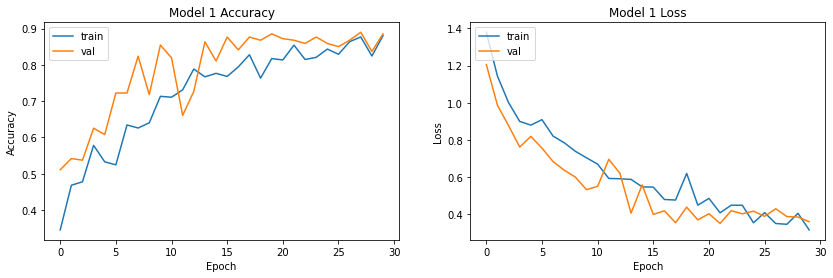

In [64]:
# Evaluate Model 1 Without Dropout Data Train Not Augmented

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model 1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model 1 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Berdasarkan plot accuracy dan Loss, dapat diperoleh informasi bahwa Model 1 tidak overfitting. Nilai accuracy berada di rentang 0.8 hingga 0.99, dan loss berada di bawah 0.4. Hal ini menunjukkan bahwa Model 1 merupakan model yang baik berdasarkan accuracy dan lossnya, karena memiliki accuracy yang tinggi dan loss yang rendah.

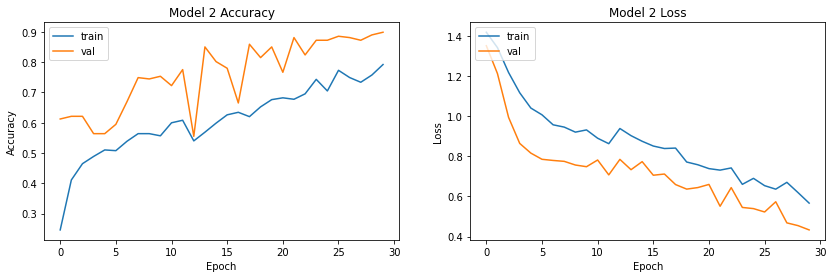

In [65]:
# Plot Evaluate Model 2 Dropout 0.5 Data Train Not Augmented

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model 2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model 2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Nilai accuracy berada di rentang 0.7 hingga 0.99, dan loss berada di bawah 0.6. Hal ini menunjukkan bahwa Model 2 merupakan model yang baik berdasarkan accuracy dan lossnya, karena memiliki accuracy yang tinggi dan loss yang rendah. Namun, jika dibandingkan dengan Model 1, dapat diketahui bahwa Model 2  underfitting. Karena nilai accuracy train lebih rendah dari =pada nilai accuracy test. Begitu pula jika dilihat dari nilai lossnya, nilai loss data train lebih tinggi dibandingkan nilai loss data validation. Dapat diartikan bahwa penambahan dropout justru membuat model yang sebelumnya good fit menjadi underfitting.

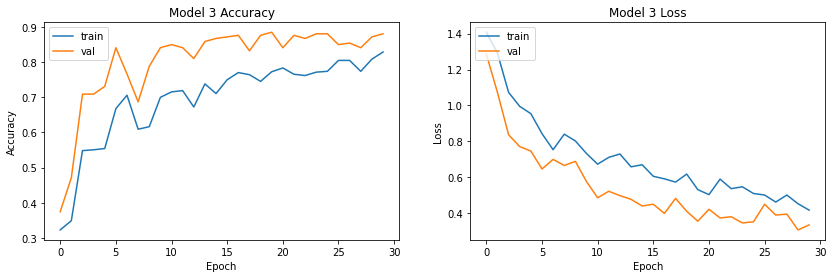

In [66]:
# Plot Evaluate Model 3 Without Dropout, Dense Hidden Layer 2, Data Train Augmented

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model 3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model 3 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model 3 tidak overfitting jika dilihat pada plot accuracy dan Lossnya. Nilai accuracy berada di rentang 0.8 hingga 0.99, dan loss berada di bawah 0.5. Hal ini menunjukkan bahwa Model 3 merupakan model yang baik berdasarkan accuracy dan lossnya, karena memiliki accuracy yang tinggi dan loss yang rendah. Jika dibandingkan dengan Model 1, dapat dilihat bahwa Model 3 lebih baik karena Model 3 memiliki accuracy yang lebih tinggi dan nilai loss yang lebih rendah. Dapat diartikan bahwa data train yang diaugmentasi merupakan data train yang lebih baik daripada data train yang tidak diaugmentasi.

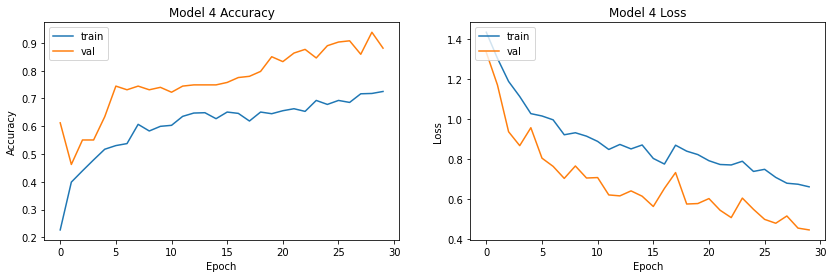

In [67]:
# Plot Evaluate Model 4 Dropout 0.5, Dense Hidden Layer 2, Data Train Augmented

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model 4 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('Model 4 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Nilai accuracy berada di rentang 0.7 hingga 0.99, dan loss berada di bawah 0.8. Hal ini menunjukkan bahwa Model 4 merupakan model yang baik berdasarkan accuracy dan lossnya, karena memiliki accuracy yang tinggi dan loss yang rendah. Namun, jika dibandingkan dengan Model 3, dapat diketahui bahwa Model 4  underfitting karena nilai accuracy train lebih rendah dari =pada nilai accuracy test. Begitu pula jika dilihat dari nilai lossnya, nilai loss data train lebih tinggi dibandingkan nilai loss data validation. Dapat diartikan bahwa penambahan dropout justru membuat model yang sebelumnya good fit menjadi underfitting.

## Classification Report

In [68]:
# Classification Report Model 1

#Predict classes
test_steps_per_epoch = np.math.ceil(val_data.samples / val_data.batch_size)

predictions = model_1.predict(val_data, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1) 

# Get ground-truth classes and class-labels
true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())    

# Use scikit-learn to get statistics
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  

              precision    recall  f1-score   support

      cloudy       0.88      0.79      0.83        57
        rain       0.85      0.79      0.81        42
       shine       0.76      0.91      0.83        43
     sunrise       0.98      0.99      0.98        85

    accuracy                           0.89       227
   macro avg       0.87      0.87      0.87       227
weighted avg       0.89      0.89      0.89       227



Model 1 merupakan model yang baik dalam mengklasifikasikan weather image, karena memiliki nilai precision, recall, f1-score yang lebih dari 80%. 

Precision terendah adalah 0.76 untuk class shine, artinya tingkat akurasi weather image yang benar mengklasifikasikan ke dalam shine dari keseluruhan prediksi untuk kelas shine adalah 76%. Hal ini kemungkinan terjadi karena ada beberapa ciri khas dari kelas shine yang dimiliki oleh kelas lain. Misalnya gambar awan di kelas cloudy dan kelas shine. Kedua kelas tersebut sama-sama memiliki ciri khas yaitu memiliki gambar awan.

Recall tertinggi adalah sunrise yakni hingga mencapai 100% atau 99%, artinya tingkat akurasi weather image yang diprediksi tidak termasuk dalam kelas sunrise dibandingkan yang benar bukan termasuk dalam kelas sunrise adalah 100%. Penyebab dari hal ini kemungkinan karena kelas sunrise memiliki ciri khas yang berbeda dari kelas lain.

In [69]:
# Classification Report Model 2

# Predict classes
test_steps_per_epoch = np.math.ceil(val_data.samples / val_data.batch_size)

predictions = model_2.predict(val_data, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1) 

# Get ground-truth classes and class-labels
true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())    

# Use scikit-learn to get statistics
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  

              precision    recall  f1-score   support

      cloudy       0.92      0.81      0.86        57
        rain       0.84      0.88      0.86        42
       shine       0.80      0.84      0.82        43
     sunrise       0.97      1.00      0.98        85

    accuracy                           0.90       227
   macro avg       0.88      0.88      0.88       227
weighted avg       0.90      0.90      0.90       227



Model 2 merupakan model yang baik dalam mengklasifikasikan weather image, karena memiliki nilai precision, recall, f1-score yang lebih dari 80%. Dibandingkan dengan Model 1, model 2 lebih baik karena nilai precision di semua kelas di atas 80%.

In [70]:
# Classification Report Model 3

# Predict classes
test_steps_per_epoch = np.math.ceil(val_data.samples / val_data.batch_size)

predictions = model_3.predict(val_data, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1) 

# Get ground-truth classes and class-labels
true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())    

# Use scikit-learn to get statistics
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  

              precision    recall  f1-score   support

      cloudy       0.81      0.77      0.79        57
        rain       0.91      0.74      0.82        42
       shine       0.77      0.93      0.84        43
     sunrise       0.98      1.00      0.99        85

    accuracy                           0.88       227
   macro avg       0.87      0.86      0.86       227
weighted avg       0.88      0.88      0.88       227



Model 3 merupakan model yang baik dalam mengklasifikasikan weather image, karena memiliki nilai precision, recall, f1-score yang lebih dari 80%. Sama seperti model 1, precision untuk kelas shine memiliki nilai di bawah 80% lebih tepatnya 79%.  Hal ini menunjukkan tingkat akurasi weather image yang benar mengklasifikasikan ke dalam shine dari keseluruhan prediksi untuk kelas shine adalah 79%.

In [71]:
# Classification Report Model 4

# Predict classes
test_steps_per_epoch = np.math.ceil(val_data.samples / val_data.batch_size)

predictions = model_4.predict(val_data, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1) 

# Get ground-truth classes and class-labels
true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())    

# Use scikit-learn to get statistics
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  

              precision    recall  f1-score   support

      cloudy       0.97      0.63      0.77        57
        rain       0.74      0.95      0.83        42
       shine       0.81      0.91      0.86        43
     sunrise       0.97      1.00      0.98        85

    accuracy                           0.88       227
   macro avg       0.87      0.87      0.86       227
weighted avg       0.90      0.88      0.88       227



Model 4 merupakan model yang baik dalam mengklasifikasikan weather image, karena memiliki nilai precision, recall, f1-score yang lebih dari 80%. Dibandingkan dengan Model 3, model 4 lebih baik karena nilai precision pada data validation di semua kelas di atas 80%.

## Best Model Selection

Model terbaik akan dipilih berdasarkan nilai accuracy dan loss. Model terbaik adalah model yang memiliki nilai accuracy yang paling tinggi dan nilai loss yang paling rendah.

In [72]:
# Create Metrics Evaluation Dataframe
metrics_eval = pd.DataFrame({'Model': [],
                             'Dropout': [],
                             'Data Train Augmented': [],
                             'Loss':[],
                             'Accuracy':[]})

# Loss & Accuracy Model 1
score_model_1 = model_1.evaluate(val_data)
loss_1 = score_model_1[0]
accuracy_1 =  score_model_1[1]

# Loss & Accuracy Model 2
score_model_2 = model_2.evaluate(val_data)
loss_2 = score_model_2[0]
accuracy_2 =  score_model_2[1]

# Loss & Accuracy Model 3
score_model_3 = model_3.evaluate(val_data)
loss_3 = score_model_3[0]
accuracy_3 =  score_model_3[1]

# Loss & Accuracy Model 4
score_model_4 = model_4.evaluate(val_data)
loss_4 = score_model_4[0]
accuracy_4 =  score_model_4[1]

8/8 [==============================] - 1s 146ms/step - loss: 0.4451 - accuracy: 0.8811


Berikut adalah nilai accuracy dan loss dari masing-masing model.

In [73]:
# Metrics Evaluation
r = metrics_eval.shape[0]
metrics_eval.loc[r] = ['Convolutional Neural Network', '-', 'No', loss_1, accuracy_1]
metrics_eval.loc[r+1] = ['Convolutional Neural Network', '0.5', 'No', loss_2, accuracy_2]
metrics_eval.loc[r+2] = ['Convolutional Neural Network', '-', 'Yes', loss_3, accuracy_3]
metrics_eval.loc[r+3] = ['Convolutional Neural Network', '0.5', 'Yes', loss_4, accuracy_4]
metrics_eval

,Model,Dropout,Data Train Augmented,Loss,Accuracy
0,Convolutional Neural Network,-,No,0.360426,0.885463
1,Convolutional Neural Network,0.5,No,0.432847,0.898678
2,Convolutional Neural Network,-,Yes,0.333599,0.881057
3,Convolutional Neural Network,0.5,Yes,0.445050,0.881057


Berdasarkan data tersebut, dapat disimpulkan bahwa model terbaik adalah Model 3 yaitu model Convolutional Neural Network dengan parameter tertentu, tanpa penambahan dropout, dan data yang ditrain adalah data train yang di-*augmented*. Hal ini karena Model 3 memiliki nilai accuracy yang paling tinggi dan loss yang paling rendah dibandingkan model lain.

# 9. Model Saving

Dengan melihat hasil evaluasi model, model terbaik yaitu model 3 akan disimpan. Model terbaik ini akan digunakan kembali dalam melakukan deployment di Heroku. Link Heroku untuk analisis ini adalah sebagai berikut : https://ade-cnn-weather.herokuapp.com/.

In [74]:
# Saving and Loading the .h5 Model
 
# Save Model
model_3.save('/content/gdrive/MyDrive/weather_cnn/final_model.h5')
print('Model Saved!')
 
# Load Model
final_model = load_model('/content/gdrive/MyDrive/weather_cnn/final_model.h5')
final_model.summary()

Model Saved!
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 26, 

# 10. Model Inference

Model yang sudah dilatih akan dicoba pada data inference. Data inference yang digunakan adalah data  yang bukan termasuk ke dalam train-set ataupun test-set, data tersebut berada di folder `weather_img/`. Berikut adalah fungsi untuk memprediksi class pada data inference.

In [75]:
def predict(path):
    """This functions returns predictions for a given input image

    Parameters: 
    path: path of the image to predict

    """
    #Creating a dictionary of classes as the predict function gives probablities
    actualClasses = { 0:'Cloudy',1:'Rain',2:'Shine',3:'Sunrise' }

    img = image.load_img(path, target_size = (224, 224))
    img_array = image.img_to_array(img)

    #Plotting the image
    plt.imshow(img_array/255)
    plt.show()
    img_array = np.expand_dims(img_array, axis=0)

    #Prediction
    pred = final_model.predict(img_array)
    classes = np.argmax(pred)
    return 'Predicted Class : {}'.format(actualClasses[classes])

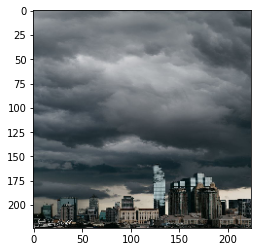

'Predicted Class : Cloudy'

In [77]:
predict(path='/content/gdrive/MyDrive/weather_cnn/weather_img/1.jpg')

Model dapat memprediksi Gambar 1 ke dalam kelas cloudy.

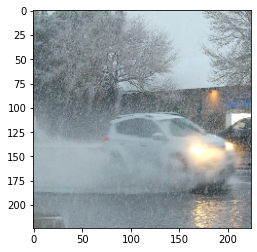

'Predicted Class : Cloudy'

In [78]:
predict(path='/content/gdrive/MyDrive/weather_cnn/weather_img/2.jpg')

Model dapat memprediksi Gambar 2 ke dalam class rain.

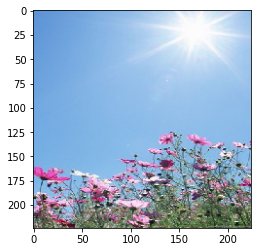

'Predicted Class : Shine'

In [79]:
predict(path='/content/gdrive/MyDrive/weather_cnn/weather_img/3.jpg')

Model dapat memprediksi Gambar 3 ke dalam class shine.

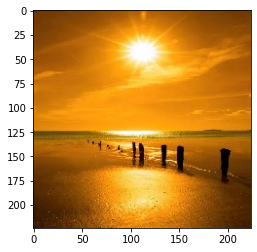

'Predicted Class : Sunrise'

In [80]:
predict(path='/content/gdrive/MyDrive/weather_cnn/weather_img/4.jpg')

Model dapat memprediksi Gambar 4 ke dalam kelas sunrise.

Dapat disimpulkan bahwa model terbaik, yaitu Model 3 dapat digunakan untuk mengklasifikasikan weather ke dalam 4 kelas (cloudy, rain, shine, dan sunrise).

## 11. Conclusion

Berikut adalah kesimpulan untuk analisis ini :
1. Terdapat empat kelas cuaca pada data train maupun test, yaitu cloudy, rain, shine, dan sunrise. Pada data train, kelas dengan data tertinggi yaitu sunrise, yakni 273 gambar. Kedua adalah cloudy, yakni 230 gambar. Ketiga adalah rain, yakni 173 gambar. Yang terakhir adalah shine berisi 161 gambar.
2. Model yang digunakan adalah model Convolutional Neural Network (CNN) dan pendefinisiannya menggunakan Sequential API. Model yang akan diuji coba adalah 
  - Base model atau model 1, yaitu model dengan parameter tertentu tanpa dropout dan data train bukan augmented, 
  - Model 2, yaitu model 1 dengan penambahan dropout 0.5, 
  - Model 3, yaitu model dengan parameter tertentu tanpa dropout dan data train augmented, 
  - Model 4, yaitu model 3 dengan penambahan dropout 0.5.

3. Berdasarkan plot accuracy dan lossnya, model 1 dan 3 tidak overfitting, dan model 2 dan 4 underfitting. Hal ini menunjukkan bahwa penambahan dropout pada model yang sebelumnya goodfit akan membuat model menjadi underfit.

4. Model terbaik adalah Model 3 yaitu model Convolutional Neural Network dengan parameter tertentu, tanpa penambahan dropout, dan data yang ditrain adalah data train yang di-*augmented*. Hal ini karena Model 3 memiliki nilai accuracy yang paling tinggi dan loss yang paling rendah dibandingkan model lain.

5. Berdasarkan data inference, Model tersebut dapat digunakan untuk mengklasifikasikan weather ke dalam 4 kelas (cloudy, rain, shine, dan sunrise).

**link heroku** : https://ade-cnn-weather.herokuapp.com/

**link google colab** : https://colab.research.google.com/drive/1osJnmLnb3DD2hD0yUfZEvppfFtUnB8EE?usp=sharing